In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet
warnings.filterwarnings('ignore')


In [5]:
!pip install prophet

# Loading Data

In [6]:
df = pd.read_csv('women_in_stem.csv')

In [7]:
df.head(15)

,Country,Year,Female Enrollment (%),Female Graduation Rate (%),STEM Fields,Gender Gap Index
0,China,2018,20.4,43.2,Engineering,0.52
1,China,2005,35.6,29.3,Mathematics,0.98
2,China,2005,53.7,32.4,Biology,0.60
3,Germany,2007,65.0,63.6,Mathematics,0.69
4,Canada,2010,54.4,28.8,Engineering,0.74
5,India,2001,53.0,54.5,Computer Science,0.54
6,Canada,2002,69.0,23.2,Engineering,0.86
7,India,2000,29.5,38.1,Engineering,0.90
8,USA,2014,57.1,35.7,Biology,0.61
9,China,2020,36.7,64.3,Computer Science,0.96


##### We notice that row 2 and row 14 are both data for China 2005 Biology. This is because the dataset incorporated data from multiple sources. So, we check for all repeated data points:

In [8]:
df_count=df.groupby(['Country','Year','STEM Fields'], as_index=False).agg({'Female Enrollment (%)':'count'})
df_count=df_count.rename(columns={'Female Enrollment (%)':'Count'})
df_count=df_count[df_count['Count']>=2]
df_count

,Country,Year,STEM Fields,Count
1,Australia,2000,Computer Science,3
3,Australia,2000,Mathematics,2
6,Australia,2001,Mathematics,3
7,Australia,2002,Mathematics,2
8,Australia,2003,Computer Science,3
...,...,...,...,...
325,USA,2017,Engineering,3
334,USA,2021,Biology,2
337,USA,2022,Biology,3
338,USA,2022,Engineering,3


##### there are 110 repeated data points. It is nearly impossible to check the sources of all the data and choose a more credible one, so we use the average of multiple sources for each datapoint:

In [9]:
#Keep one average for each data on one country, one field in one year.
df=df.groupby(['Country','Year','STEM Fields'],
            as_index=False).agg({'Female Enrollment (%)':'mean',
                                'Female Graduation Rate (%)':'mean',
                                'Gender Gap Index':'mean'})

# Data Overview

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     344 non-null    object 
 1   Year                        344 non-null    int64  
 2   STEM Fields                 344 non-null    object 
 3   Female Enrollment (%)       344 non-null    float64
 4   Female Graduation Rate (%)  344 non-null    float64
 5   Gender Gap Index            344 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 16.3+ KB


In [11]:
df.drop('Year', axis = 1).describe()

,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index
count,344.000000,344.000000,344.000000
mean,43.899680,36.552524,0.749739
std,12.969551,14.559160,0.127910
min,20.100000,10.500000,0.500000
25%,34.550000,24.537500,0.650000
50%,43.683333,36.610000,0.750000
75%,53.900000,48.200000,0.850000
max,69.400000,64.800000,1.000000


Female Enrollment:

- Mean: 43.9% - Below 50%, indicating global underrepresentation
- Range: 20.1% - 69.5% - Wide variation between countries
- SD: 12.9% - Significant disparities exist
-  Key Insight: Most countries have female STEM enrollment below 50%, showing a persistent gender imbalance in STEM education worldwide.

Gender Gap Index:

- Mean: 0.749 - On average, 25% gap from perfect parity
- Best: 1.00 - Some countries achieved full equality
- Worst: 0.50 - Severe inequality in lowest performers

Female Graduation Rate:

- Min: 10.5% - is very small percent for graduation in a country
- Max: 64.8% 
- Mean: 36.55% - is less than the enrollment, why?
***************************************************
- Female Enrollment Mean:    43.9%
- Female Graduation Mean:    36.7%
- Gap:                       -7.2%
- Insight: Women are entering STEM but not graduating at the same rate - suggesting a dropout or retention issue that requires investigation.

In [12]:
worst_enrollment = df.nsmallest(5, 'Female Enrollment (%)')
best_enrollment = df.nlargest(5, 'Female Enrollment (%)')

In [13]:
worst_enrollment

,Country,Year,STEM Fields,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index
86,Canada,2012,Computer Science,20.1,27.2,0.97
159,China,2018,Engineering,20.4,43.2,0.52
231,India,2001,Engineering,20.4,18.2,0.58
207,Germany,2015,Engineering,20.6,61.9,0.92
300,USA,2006,Engineering,20.7,22.4,0.52


In [14]:
best_enrollment

,Country,Year,STEM Fields,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index
83,Canada,2010,Mathematics,69.4,28.2,0.89
90,Canada,2013,Engineering,69.1,32.9,0.54
153,China,2016,Computer Science,68.7,34.7,0.51
168,China,2022,Biology,68.5,37.9,0.52
315,USA,2013,Mathematics,68.4,32.8,0.75


In [15]:
worst_graduation = df.nsmallest(5, 'Female Graduation Rate (%)')
best_graduation = df.nlargest(5, 'Female Graduation Rate (%)')

In [16]:
worst_graduation

,Country,Year,STEM Fields,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index
52,Australia,2021,Mathematics,41.2,10.5,0.70
184,Germany,2005,Mathematics,31.1,10.6,0.76
196,Germany,2010,Biology,29.5,10.9,0.98
221,Germany,2021,Computer Science,45.8,10.9,0.92
304,USA,2007,Mathematics,39.1,10.9,0.91


In [17]:
best_graduation

,Country,Year,STEM Fields,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index
150,China,2015,Biology,42.9,64.8,0.80
179,Germany,2003,Biology,43.4,64.7,0.78
164,China,2020,Computer Science,36.7,64.3,0.96
216,Germany,2019,Computer Science,21.5,64.1,0.77
295,USA,2004,Computer Science,47.5,64.1,0.73


In [18]:
df['Dropout_Rate'] = df['Female Enrollment (%)'] - df['Female Graduation Rate (%)']

In [19]:
df

,Country,Year,STEM Fields,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index,Dropout_Rate
0,Australia,2000,Biology,68.200000,62.500000,0.990000,5.700000
1,Australia,2000,Computer Science,34.400000,28.533333,0.843333,5.866667
2,Australia,2000,Engineering,68.000000,31.300000,0.510000,36.700000
3,Australia,2000,Mathematics,52.900000,35.350000,0.870000,17.550000
4,Australia,2001,Computer Science,51.100000,50.700000,0.630000,0.400000
...,...,...,...,...,...,...,...
339,USA,2022,Mathematics,56.800000,41.400000,0.910000,15.400000
340,USA,2023,Biology,38.233333,25.433333,0.650000,12.800000
341,USA,2023,Computer Science,32.400000,11.000000,0.520000,21.400000
342,USA,2023,Engineering,26.700000,22.800000,0.890000,3.900000


In [20]:
df['Country'].nunique()

6

In [21]:
df['STEM Fields'].value_counts()

STEM Fields
Mathematics         94
Engineering         91
Biology             83
Computer Science    76
Name: count, dtype: int64

In [22]:
df.duplicated().sum()

0

In [23]:
numeric_cols = ['Female Enrollment (%)', 'Female Graduation Rate (%)', 'Gender Gap Index']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n{col}:")
    print(f"  - Lower bound: {lower_bound:.2f}")
    print(f"  - Upper bound: {upper_bound:.2f}")
    print(f"  - Number of outliers: {len(outliers)}")



Female Enrollment (%):
  - Lower bound: 5.52
  - Upper bound: 82.92
  - Number of outliers: 0

Female Graduation Rate (%):
  - Lower bound: -10.96
  - Upper bound: 83.69
  - Number of outliers: 0

Gender Gap Index:
  - Lower bound: 0.35
  - Upper bound: 1.15
  - Number of outliers: 0


# Visualizations

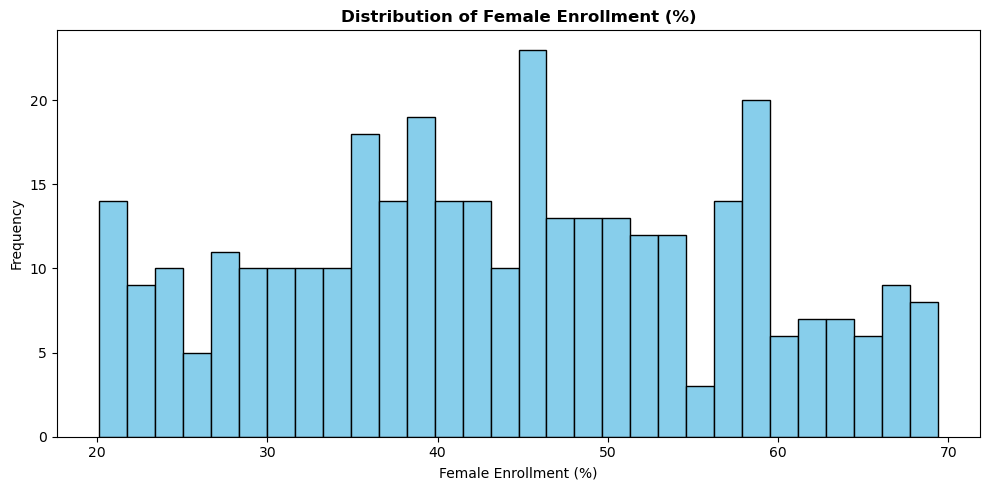

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

#Distribution of Female Enrollment
ax.hist(df['Female Enrollment (%)'], bins=30, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Female Enrollment (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Female Enrollment (%)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

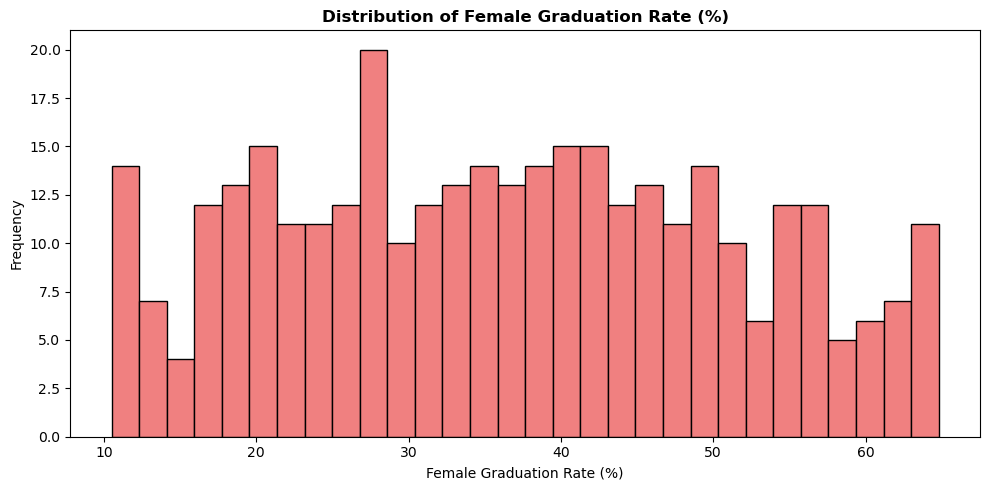

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

#Distribution of Female Graduation Rate
ax.hist(df['Female Graduation Rate (%)'], bins=30, color='lightcoral', edgecolor='black')
ax.set_title('Distribution of Female Graduation Rate (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Female Graduation Rate (%)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


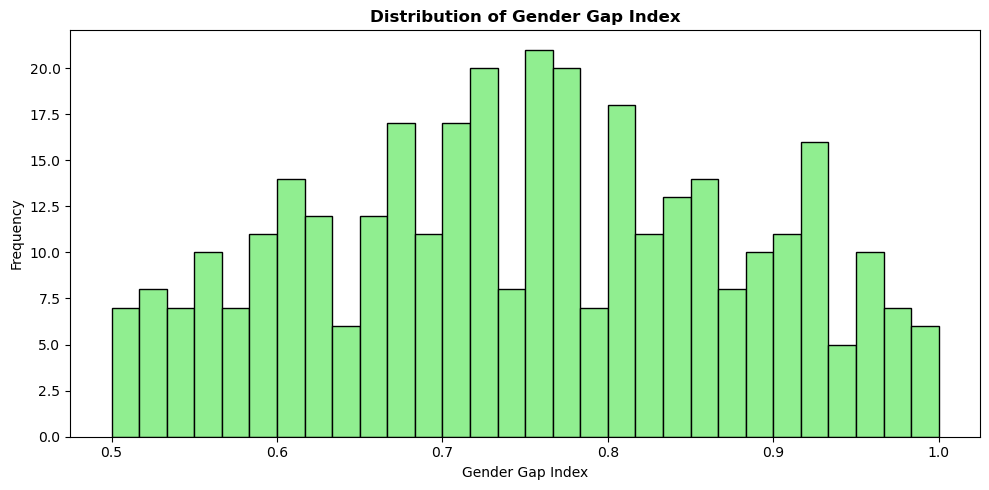

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

#Distribution of Gender Gap Index
ax.hist(df['Gender Gap Index'], bins=30, color='lightgreen', edgecolor='black')
ax.set_title('Distribution of Gender Gap Index', fontsize=12, fontweight='bold')
ax.set_xlabel('Gender Gap Index')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

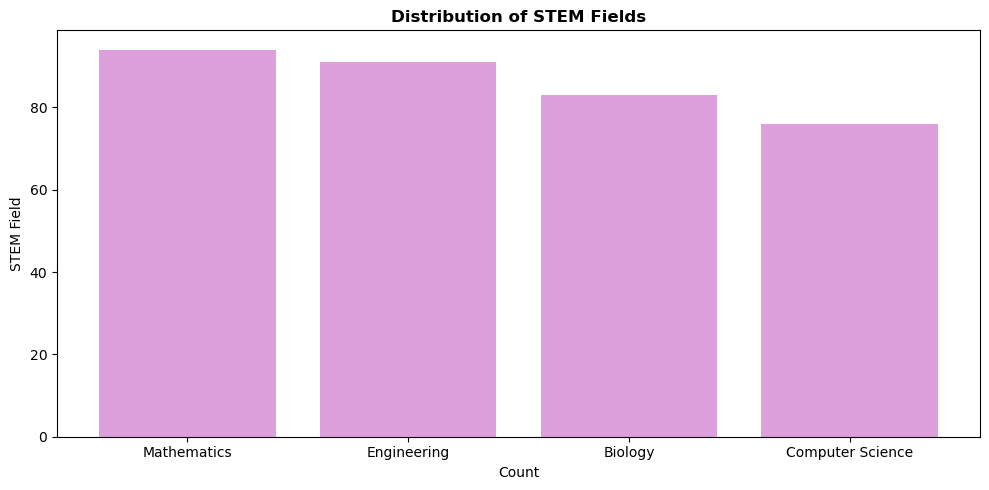

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

field_counts = df['STEM Fields'].value_counts()
ax.bar(field_counts.index, field_counts.values, color='plum')
ax.set_title('Distribution of STEM Fields', fontsize=12, fontweight='bold')
ax.set_xlabel('Count')
ax.set_ylabel('STEM Field')
plt.tight_layout()
plt.show()

([0, 1, 2, 3],
 [Text(0, 0, 'Biology'),
  Text(1, 0, 'Computer Science'),
  Text(2, 0, 'Engineering'),
  Text(3, 0, 'Mathematics')])

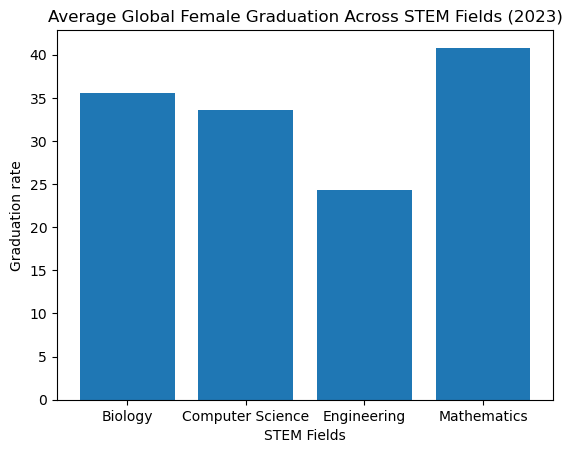

In [28]:
df_copy=df[df["Year"]==2023]
df_copy=df_copy.drop(columns=["Female Enrollment (%)", "Gender Gap Index", "Country", "Year"])
df_copy= df_copy.groupby('STEM Fields')['Female Graduation Rate (%)'].agg({'mean'})

graph_one = plt.bar(df_copy.index.tolist(), df_copy['mean']) 

plt.title('Average Global Female Graduation Across STEM Fields (2023)')
plt.xlabel('STEM Fields')
plt.ylabel('Graduation rate')
plt.xticks(rotation=0) 

In 2023, mathematics had the highest female graduation percentage, reaching nearly 50 percent. 
Meanwhile, engineering trailed behind at the end with around 25 percent graduation.

# EDA

In [29]:
yearly_stats = df.groupby('Year').agg({
    'Female Enrollment (%)': 'mean',
    'Female Graduation Rate (%)': 'mean',
    'Gender Gap Index': 'mean',
    'Dropout_Rate': 'mean'
}).round(2)
yearly_stats

,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index,Dropout_Rate
Year,,,,
2000,48.48,34.16,0.80,14.32
2001,42.94,34.63,0.67,8.31
2002,43.46,34.33,0.73,9.13
2003,45.67,38.33,0.72,7.34
2004,44.42,38.43,0.76,6.00
2005,42.50,34.87,0.77,7.63
2006,44.29,34.42,0.71,9.87
2007,45.45,35.82,0.74,9.63
2008,35.41,33.15,0.72,2.27


In [30]:
yearly_stats['Enrollment_Change'] = yearly_stats['Female Enrollment (%)'].diff()
yearly_stats['Enrollment_Change']

Year
2000      NaN
2001    -5.54
2002     0.52
2003     2.21
2004    -1.25
2005    -1.92
2006     1.79
2007     1.16
2008   -10.04
2009     9.77
2010     0.68
2011    -5.57
2012     0.35
2013     4.29
2014    -1.18
2015    -0.59
2016    -4.62
2017     9.57
2018     0.50
2019     0.25
2020    -4.43
2021     0.75
2022    -2.70
2023    -4.20
Name: Enrollment_Change, dtype: float64

In [31]:
yearly_stats['GGI_Change'] = yearly_stats['Gender Gap Index'].diff()
yearly_stats['GGI_Change']

Year
2000     NaN
2001   -0.13
2002    0.06
2003   -0.01
2004    0.04
2005    0.01
2006   -0.06
2007    0.03
2008   -0.02
2009   -0.02
2010    0.10
2011    0.05
2012   -0.08
2013   -0.02
2014    0.01
2015    0.02
2016   -0.03
2017    0.01
2018   -0.03
2019    0.07
2020   -0.07
2021    0.03
2022   -0.02
2023   -0.03
Name: GGI_Change, dtype: float64

In [32]:
Canada_trend = df[df['Country'] == 'Canada'].groupby('Year')['Female Enrollment (%)'].mean()
Canada_trend

Year
2000    39.550000
2001    47.550000
2002    54.777778
2003    43.033333
2004    67.050000
2005    46.590000
2006    40.287500
2007    52.600000
2008    39.333333
2009    34.225000
2010    55.700000
2011    29.300000
2012    34.550000
2013    57.400000
2014    54.850000
2015    53.616667
2016    25.833333
2017    41.400000
2018    60.166667
2019    54.583333
2020    57.000000
2021    51.625000
2022    40.900000
2023    47.400000
Name: Female Enrollment (%), dtype: float64

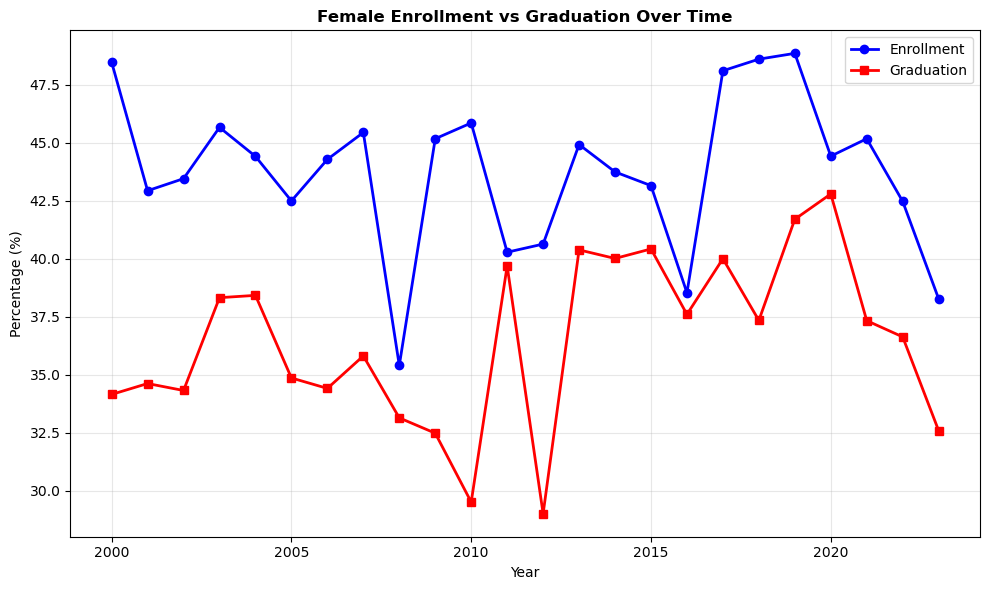

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yearly_stats.index, yearly_stats['Female Enrollment (%)'], 
                marker='o', linewidth=2, label='Enrollment', color= 'blue')
ax.plot(yearly_stats.index, yearly_stats['Female Graduation Rate (%)'], 
                marker='s', linewidth=2, label='Graduation', color='red')
ax.set_title('Female Enrollment vs Graduation Over Time', fontweight='bold', fontsize=12)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage (%)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

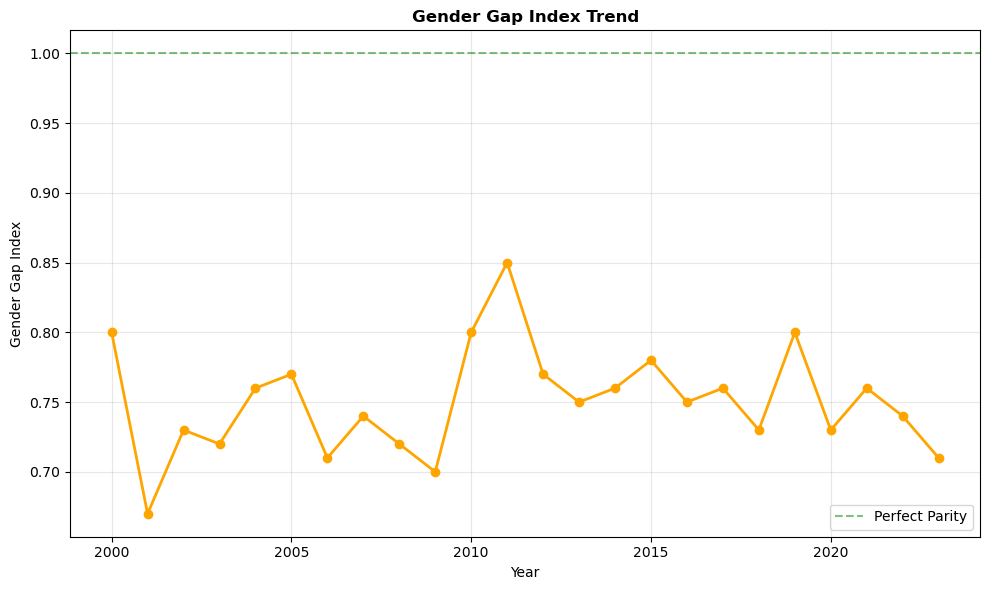

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(yearly_stats.index, yearly_stats['Gender Gap Index'], 
                marker='o', linewidth=2, color='orange')
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Parity')
ax.set_title('Gender Gap Index Trend', fontweight='bold', fontsize=12)
ax.set_xlabel('Year')
ax.set_ylabel('Gender Gap Index')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()


In [35]:
country_avg = df.groupby('Country').agg({
    'Female Enrollment (%)': 'mean',
    'Female Graduation Rate (%)': 'mean',
    'Gender Gap Index': 'mean',
    'Dropout_Rate': 'mean'
}).round(2)
country_avg

,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index,Dropout_Rate
Country,,,,
Australia,44.73,36.44,0.76,8.29
Canada,46.03,38.81,0.76,7.22
China,42.57,36.51,0.74,6.07
Germany,42.06,35.01,0.77,7.05
India,41.98,36.13,0.75,5.85
USA,45.90,36.35,0.72,9.55


In [36]:
fields_analysis = df.groupby('STEM Fields').agg({
    'Female Enrollment (%)': ['mean', 'std', 'min', 'max'],
    'Female Graduation Rate (%)': ['mean', 'std'],
    'Gender Gap Index': ['mean', 'std'],
    'Dropout_Rate': 'mean',
    'Country': 'count'
}).round(2)
fields_analysis

Female Enrollment (%)                     \
                                  mean    std   min   max   
STEM Fields                                                 
Biology                          42.98  12.43  21.0  68.5   
Computer Science                 43.34  13.52  20.1  68.7   
Engineering                      43.91  13.38  20.4  69.1   
Mathematics                      45.16  12.69  20.8  69.4   

                 Female Graduation Rate (%)        Gender Gap Index        \
                                       mean    std             mean   std   
STEM Fields                                                                 
Biology                               36.44  15.52             0.77  0.12   
Computer Science                      36.97  13.29             0.73  0.14   
Engineering                           37.96  15.12             0.74  0.13   
Mathematics                           34.95  14.18             0.76  0.12   

                 Dropout_Rate Country  
                         mean   count  
STEM Fields                            
Biology                  6.53      83  
Computer Science         6.36      76  
Engineering              5.95      91  
Mathematics             10.21      94

In [37]:
worst_field = df.groupby('STEM Fields')['Gender Gap Index'].mean().idxmin()
best_field = df.groupby('STEM Fields')['Gender Gap Index'].mean().idxmax()

In [38]:
worst_field

'Computer Science'

In [39]:
best_field

'Biology'

In [40]:
corr_cols = ['Year', 'Female Enrollment (%)', 'Female Graduation Rate (%)', 
            'Gender Gap Index', 'Dropout_Rate']
correlation = df[corr_cols].corr().round(3)
correlation

,Year,Female Enrollment (%),Female Graduation Rate (%),Gender Gap Index,Dropout_Rate
Year,1.000,-0.022,0.084,0.032,-0.079
Female Enrollment (%),-0.022,1.000,0.040,-0.064,0.648
Female Graduation Rate (%),0.084,0.040,1.000,0.000,-0.735
Gender Gap Index,0.032,-0.064,0.000,1.000,-0.043
Dropout_Rate,-0.079,0.648,-0.735,-0.043,1.000


1. Female Enrollment ↔ Female Graduation Rate: 0.040 ---> Almost no correlation (near zero). ---->  There is no meaningful relationship between enrollment and graduation rates across the dataset. Countries with high female enrollment don't necessarily have high graduation rates, and vice versa. This suggests that getting women into STEM programs is independent of whether they graduate - indicating potential systemic retention issues that vary by country or field.

2. Female Enrollment ↔ Gender Gap Index: -0.064 ----> Very weak negative correlation (near zero). ----> there's almost no relationship between enrollment percentages and gender parity. Higher female enrollment doesn't strongly correlate with better gender gap scores. This could indicate that the Gender Gap Index captures broader factors beyond just enrollment (such as workforce participation, pay equity, or societal attitudes). 

3. Year ↔ Gender Gap Index: 0.032 ----> Extremely weak positive correlation (near zero). -----> Gender parity in STEM is improving very slowly over time. The correlation of 0.036 suggests almost no progress across the years in the dataset. This is concerning as it indicates that despite global awareness and initiatives, meaningful change is not happening at scale.

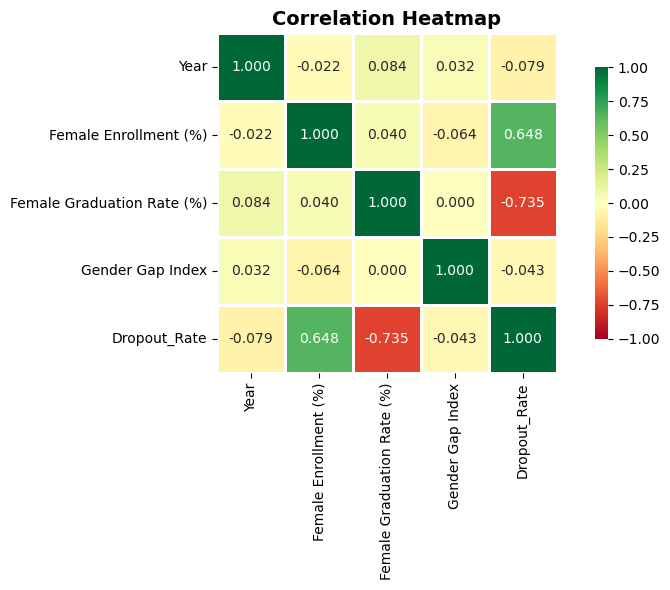

In [41]:
plt.figure(figsize=(9, 6))
sns.heatmap(correlation, annot=True, cmap='RdYlGn', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, fmt='.3f')
plt.title('Correlation Heatmap', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Machine Learning 

## Linear Regression Model

In [42]:
df_ml = df.copy()

In [43]:
features = ['Year', 'Female Enrollment (%)', 'Country_Encoded', 'Field_Encoded']

In [44]:
df_ml['Country_Encoded'] = pd.Categorical(df['Country']).codes
df_ml['Field_Encoded'] = pd.Categorical(df['STEM Fields']).codes

In [45]:
X = df_ml[features]
y = df_ml['Female Graduation Rate (%)']

In [46]:
print(f"Data Shape: {X.shape}")

Data Shape: (344, 4)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 275
Testing samples: 69


In [49]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred = lr_model.predict(X_test)

In [51]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [52]:
print(f"Model Performance:")
print(f"R² Score: {r2:.3f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Model explains {r2*100:.1f}% of the variance in graduation rates")

Model Performance:
R² Score: -0.017
MSE: 226.38
RMSE: 15.05
Model explains -1.7% of the variance in graduation rates


#### R squared is under zero, indicating that there is no linear relationship between all the features and Graduation rate feature.

# Trying open source model (Prophet -> facebook)

In [53]:
global_df = df.groupby('Year').agg({
    'Female Graduation Rate (%)': 'mean'
}).reset_index()


In [54]:
prophet_global = global_df.copy()
prophet_global.columns = ['ds', 'y']
prophet_global['ds'] = pd.to_datetime(prophet_global['ds'], format='%Y')

In [55]:
print(f"Historical data: {len(prophet_global)} years")
print(f"   From {prophet_global['ds'].dt.year.min()} to {prophet_global['ds'].dt.year.max()}")
print(f"Current average (latest year): {prophet_global['y'].iloc[-1]:.2f}%")

Historical data: 24 years
   From 2000 to 2023
Current average (latest year): 32.60%


In [56]:
model_global = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    interval_width=0.95  # 95% confidence interval
)

In [57]:
model_global.fit(prophet_global)

14:50:58 - cmdstanpy - INFO - Chain [1] start processing
14:50:58 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
future_global = model_global.make_future_dataframe(periods=8, freq='Y')

In [71]:
future_global

,ds
0,2000-01-01
1,2001-01-01
2,2002-01-01
3,2003-01-01
4,2004-01-01
5,2005-01-01
6,2006-01-01
7,2007-01-01
8,2008-01-01
9,2009-01-01


In [72]:
forecast_global = model_global.predict(future_global)

In [73]:
# Extract predictions for future years
future_predictions = forecast_global[forecast_global['ds'] > prophet_global['ds'].max()]
future_predictions['Year'] = future_predictions['ds'].dt.year

In [74]:
future_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Year
24,2023-12-31,38.711868,32.347522,45.251535,38.711868,38.711869,0.0,0.0,0.0,0.0,0.0,0.0,38.711868,2023
25,2024-12-31,38.890085,32.422321,45.075705,38.890085,38.890086,0.0,0.0,0.0,0.0,0.0,0.0,38.890085,2024
26,2025-12-31,39.067816,32.540661,45.246275,39.067815,39.067816,0.0,0.0,0.0,0.0,0.0,0.0,39.067816,2025
27,2026-12-31,39.245546,32.434385,45.548825,39.245545,39.245546,0.0,0.0,0.0,0.0,0.0,0.0,39.245546,2026
28,2027-12-31,39.423276,33.221141,45.802279,39.423275,39.423276,0.0,0.0,0.0,0.0,0.0,0.0,39.423276,2027
29,2028-12-31,39.601493,32.822611,46.406098,39.601492,39.601493,0.0,0.0,0.0,0.0,0.0,0.0,39.601493,2028
30,2029-12-31,39.779223,33.129816,46.394184,39.779222,39.779223,0.0,0.0,0.0,0.0,0.0,0.0,39.779223,2029
31,2030-12-31,39.956953,33.103224,46.503205,39.956952,39.956953,0.0,0.0,0.0,0.0,0.0,0.0,39.956953,2030


In [75]:
print("GLOBAL PREDICTIONS (2024-2030):")
for _, row in future_predictions.iterrows():
    print(f"  {int(row['Year'])}: {row['yhat']:.2f}% "
        f"(95% CI: [{row['yhat_lower']:.2f}%, {row['yhat_upper']:.2f}%])")


GLOBAL PREDICTIONS (2024-2030):
  2023: 38.71% (95% CI: [32.35%, 45.25%])
  2024: 38.89% (95% CI: [32.42%, 45.08%])
  2025: 39.07% (95% CI: [32.54%, 45.25%])
  2026: 39.25% (95% CI: [32.43%, 45.55%])
  2027: 39.42% (95% CI: [33.22%, 45.80%])
  2028: 39.60% (95% CI: [32.82%, 46.41%])
  2029: 39.78% (95% CI: [33.13%, 46.39%])
  2030: 39.96% (95% CI: [33.10%, 46.50%])


In [76]:
# Calculate growth metrics
current_rate = prophet_global['y'].iloc[-1]
predicted_2030 = future_predictions[future_predictions['Year'] == 2030]['yhat'].values[0]
total_growth = predicted_2030 - current_rate
annual_growth = total_growth / 7

In [77]:
print(f"Growth Analysis:")
print(f"  Current (2023): {current_rate:.2f}%")
print(f"  Predicted (2030): {predicted_2030:.2f}%")
print(f"  Total Growth: {total_growth:+.2f}%")
print(f"  Annual Growth Rate: {annual_growth:+.2f}% per year")

Growth Analysis:
  Current (2023): 32.60%
  Predicted (2030): 39.96%
  Total Growth: +7.35%
  Annual Growth Rate: +1.05% per year


In [78]:
# Time to reach 50% parity
if annual_growth > 0:
    years_to_50 = (50 - current_rate) / annual_growth
    year_reaching_50 = 2023 + int(years_to_50)
    print(f"  Years to 50% parity: {years_to_50:.1f} years")
    print(f"  Expected to reach 50% by: {year_reaching_50}")
else:
    print(f"  No positive growth - 50% parity unreachable at current pace")


  Years to 50% parity: 16.6 years
  Expected to reach 50% by: 2039


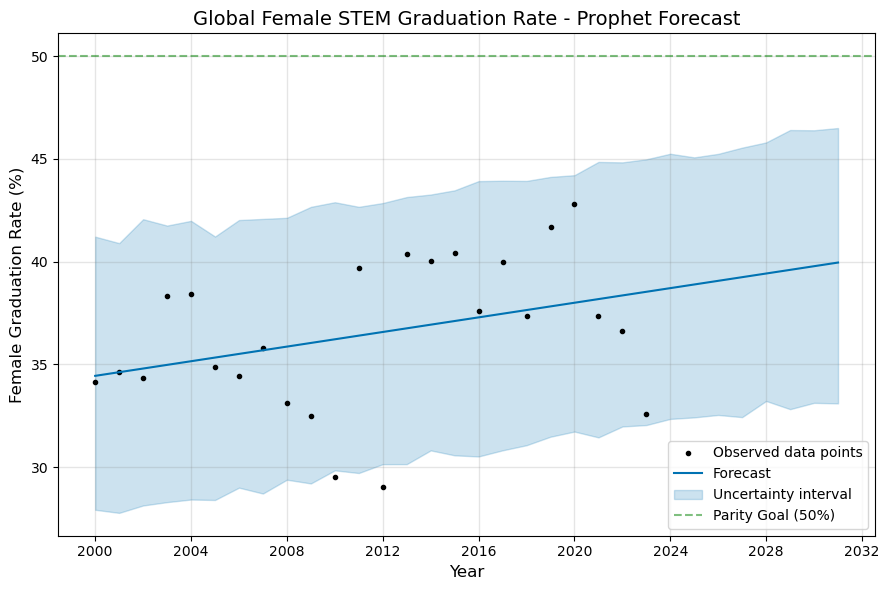

In [ ]:
# Plot 1: Global forecast
fig1 = model_global.plot(forecast_global, figsize=(9, 6))
plt.title('Global Female STEM Graduation Rate - Prophet Forecast', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Female Graduation Rate (%)', fontsize=12)
plt.axhline(y=50, color='green', linestyle='--', alpha=0.5, label='Parity Goal (50%)')
plt.legend()
plt.tight_layout()
plt.show()

"We're improving, but NOT fast enough!"

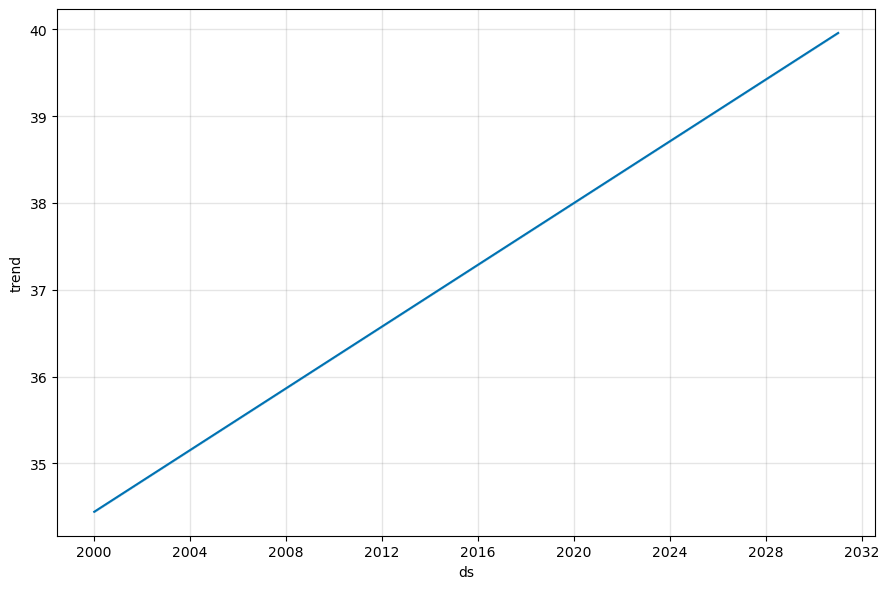

In [ ]:
# Plot 2: Components
fig2 = model_global.plot_components(forecast_global, figsize=(9, 6))
plt.tight_layout()
plt.show()

## Model Selection Rationale

Initial attempts with multiple Linear Regression failed (R²=-0.017) 
due to weak feature-target correlations (all <0.1). This failure 
revealed that traditional supervised learning approaches were 
inappropriate for this dataset.

We pivoted to **Prophet**, Facebook's time series forecasting 
algorithm, which succeeded because:

1. **Data Structure Match**: Our data is inherently temporal, and 
   Prophet is purpose-built for time series
2. **Pattern Recognition**: Prophet detects trends in sequences 
   without requiring strong cross-variable correlations
3. **Uncertainty Quantification**: Provides confidence intervals 
   reflecting forecast reliability

This model selection demonstrates the importance of matching 
algorithm to data structure rather than defaulting to standard 
supervised learning approaches.